## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [2]:
df.loc[:, ['location', 'total_deaths']].groupby('location').sum().sort_values('total_deaths', ascending=False).head(20)

,total_deaths
location,
World,729086851.0
Europe,215091326.0
North America,198194253.0
South America,169274104.0
European Union,146015460.0
United States,136774639.0
Asia,120545419.0
Brazil,83208769.0
India,52360276.0


In [3]:
brazil= df[df.location == 'Brazil'].loc[:, ['date','new_cases', 'new_deaths', 'population', 'total_cases', 'total_deaths']]
brazil.set_index('date', inplace=True)
brazil.dropna(how='any', inplace=True)
brazil

,new_cases,new_deaths,population,total_cases,total_deaths
date,,,,,
2020-03-17,121.0,1.0,212559409.0,321.0,1.0
2020-03-18,51.0,2.0,212559409.0,372.0,3.0
2020-03-19,249.0,3.0,212559409.0,621.0,6.0
2020-03-20,172.0,5.0,212559409.0,793.0,11.0
2020-03-21,228.0,4.0,212559409.0,1021.0,15.0
...,...,...,...,...,...
2021-06-16,95367.0,2997.0,212559409.0,17628588.0,493693.0
2021-06-17,74042.0,2311.0,212559409.0,17702630.0,496004.0
2021-06-18,98832.0,2495.0,212559409.0,17801462.0,498499.0


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_columns(df):
    colors = ['firebrick', 'royalblue', 'forestgreen', 'gold', 'orange']
    x_plot = np.array(df.index)
    fig, ax_left = plt.subplots(figsize=(15,10))
    ax_right = ax_left.twinx()
    for i, col in enumerate(list(df.columns)):
        if col == 'population':
            ax_right.plot(x_plot, np.array(df[col]), color=colors[i], label=col)
        else:
            ax_left.plot(x_plot, np.array(df[col]), color=colors[i], label=col)
    ax_left.legend(loc='best')
    ticks = ax_left.get_xticks()[::40]
    ax_left.set_xticks(ticks)
    ax_left.set_xlabel('Time')

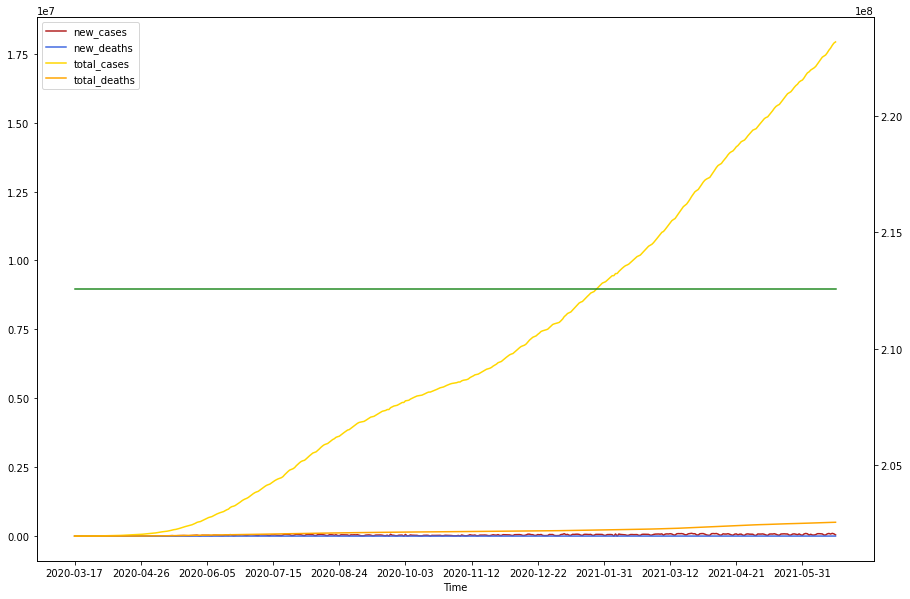

In [5]:
plot_columns(brazil)

In [6]:
brazil2 = brazil.drop('population', axis=1)
X = np.array(brazil2.loc[:, 'new_deaths':])
y = np.array(brazil2.new_cases)

In [7]:
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

def model_crossval_scores(X, y, model, splits=10, epochs=1, random_state=42, degree=False, plot=True, show_warnings=False):

    if show_warnings == False:
        warnings.filterwarnings('ignore')

    scores = {'Epoch':[],'Iteration':[],'Train_Score':[], 'Val_Score':[]}
    epoch = 1
    iteration = 1

    # Cross Validation Data Collection
    if degree:
        polinominal_model = PolynomialFeatures(degree) 
        X = polinominal_model.fit_transform(X, y)
    rkf = RepeatedKFold(n_splits=splits, n_repeats=epochs, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    for train_index, val_index in rkf.split(X_train):

        model.fit(X_train[train_index], y_train[train_index])
        train_score = model.score(X_train[train_index], y_train[train_index])
        val_score = model.score(X_train[val_index], y_train[val_index])

        scores['Train_Score'].append(train_score)
        scores['Val_Score'].append(val_score)
        scores['Iteration'].append(iteration)
        scores['Epoch'].append(epoch)
        
        iteration += 1
        if iteration > splits:
            iteration = 1
            epoch += 1

    # Epoch Plots
    df = pd.DataFrame(scores, index=range(len(scores['Val_Score'])))

    if plot:
        for e in range(1, epochs+1):
            x_plot = df[df.Epoch == e]['Iteration']
            y_plot_train = df[df.Epoch == e]['Train_Score']
            y_plot_val = df[df.Epoch == e]['Val_Score']
            fig, ax = plt.subplots()
            ax.plot(x_plot, y_plot_train, color='green', label='Train Score')
            ax.plot(x_plot, y_plot_val, color='red', label='Val Score')
            if degree:
                plt.title(f'Poly deg:{degree} | Train/Val Score | Epoch: {e}')
            else:
                plt.title(f'{model} | Train/Val Score | Epoch: {e}')
            ax.legend(loc='best')
            plt.show()

    return df

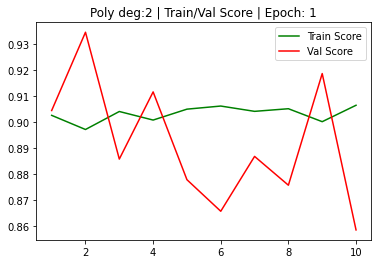

,Epoch,Iteration,Train_Score,Val_Score
0,1,1,0.902704,0.904555
1,1,2,0.897266,0.934655
2,1,3,0.904185,0.885892
3,1,4,0.900894,0.911722
4,1,5,0.905086,0.877966
5,1,6,0.906282,0.865833
6,1,7,0.904242,0.886921
7,1,8,0.905250,0.875848
8,1,9,0.900272,0.918769
9,1,10,0.906581,0.858659


In [8]:
lm = LinearRegression()
model_crossval_scores(X, y, lm, degree=2)

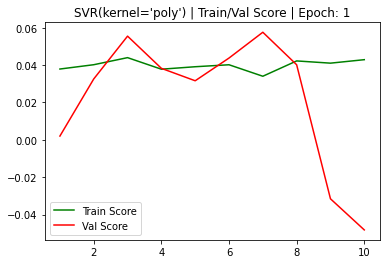

,Epoch,Iteration,Train_Score,Val_Score
0,1,1,0.037898,0.002015
1,1,2,0.040206,0.032586
2,1,3,0.043994,0.055503
3,1,4,0.037806,0.038269
4,1,5,0.039125,0.031615
5,1,6,0.040184,0.043777
6,1,7,0.034037,0.057589
7,1,8,0.042236,0.040187
8,1,9,0.041044,-0.031567
9,1,10,0.042903,-0.048225


In [15]:
svr = SVR(kernel='poly')
model_crossval_scores(X, y, svr)

In [10]:
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

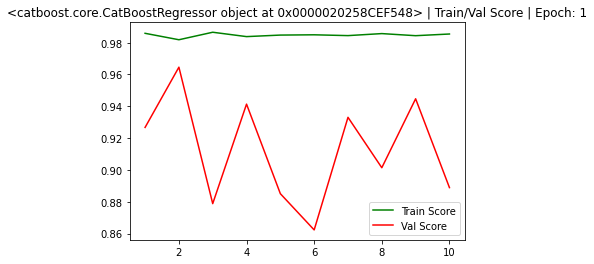

,Epoch,Iteration,Train_Score,Val_Score
0,1,1,0.985888,0.926713
1,1,2,0.981842,0.964596
2,1,3,0.986558,0.878784
3,1,4,0.983814,0.941355
4,1,5,0.984776,0.885045
5,1,6,0.984951,0.862263
6,1,7,0.984442,0.933059
7,1,8,0.985709,0.901366
8,1,9,0.984393,0.944723
9,1,10,0.985448,0.888870


In [14]:
cat = CatBoostRegressor(logging_level='Silent')
model_crossval_scores(X, y, cat)

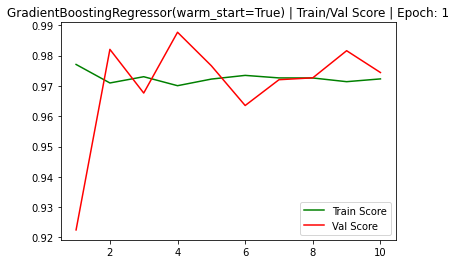

,Epoch,Iteration,Train_Score,Val_Score
0,1,1,0.977099,0.922498
1,1,2,0.970990,0.982076
2,1,3,0.973051,0.967665
3,1,4,0.970089,0.987727
4,1,5,0.972271,0.976661
5,1,6,0.973492,0.963548
6,1,7,0.972655,0.972064
7,1,8,0.972636,0.972684
8,1,9,0.971416,0.981633
9,1,10,0.972331,0.974435


In [16]:
grad = GradientBoostingRegressor(warm_start=True)
model_crossval_scores(X, y, grad)

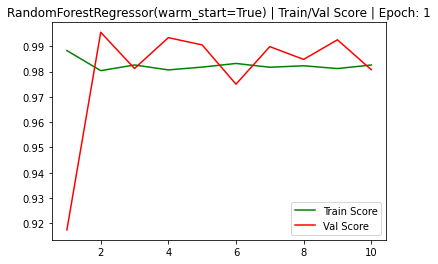

,Epoch,Iteration,Train_Score,Val_Score
0,1,1,0.988276,0.917369
1,1,2,0.980348,0.995529
2,1,3,0.982586,0.981191
3,1,4,0.980638,0.993400
4,1,5,0.981748,0.990505
5,1,6,0.983185,0.974994
6,1,7,0.981686,0.989846
7,1,8,0.982272,0.984786
8,1,9,0.981168,0.992544
9,1,10,0.982579,0.980720


In [17]:
rfr = RandomForestRegressor(warm_start=True)
model_crossval_scores(X, y, rfr)

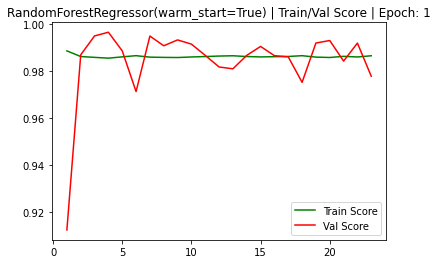

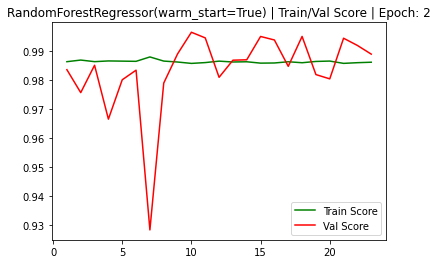

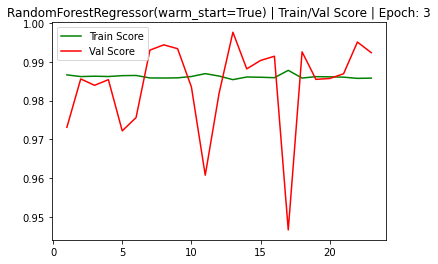

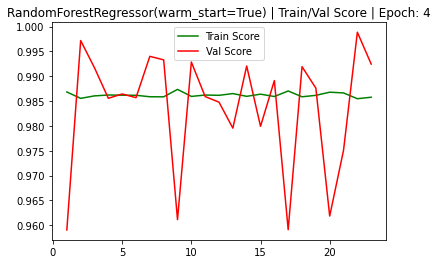

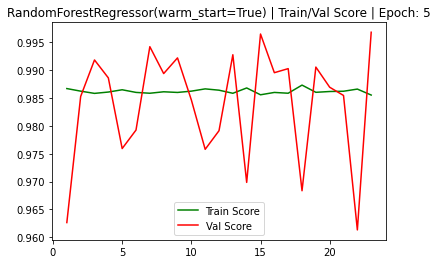

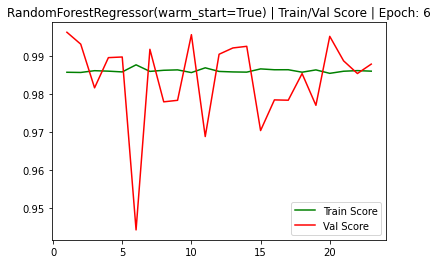

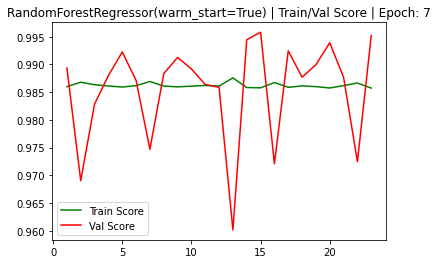

,Epoch,Iteration,Train_Score,Val_Score
0,1,1,0.988578,0.912608
1,1,2,0.986192,0.986903
2,1,3,0.985827,0.994936
3,1,4,0.985492,0.996490
4,1,5,0.986042,0.988594
...,...,...,...,...
156,7,19,0.985995,0.989945
157,7,20,0.985751,0.993899
158,7,21,0.986176,0.987673
159,7,22,0.986646,0.972456


In [19]:
rfr2 = RandomForestRegressor(warm_start=True)
model_crossval_scores(X, y, rfr2, splits=23, epochs=7)